In [1]:
import os
import numpy as np
import sympy as sym
import pandas as pd
from lmfit import Model
from lumicks import pylake
from denseweight import DenseWeight
from matplotlib import pyplot as plt

In [2]:
def coth1(x):
    """
    Compute the hyperbolic cotangent of x.

    :param x: Input value, can be a sympy Float or a numeric type.
    :return: Hyperbolic cotangent of x.
    """
    if type(x) == sym.core.numbers.Float:
        # If x is a sympy Float, use the sympy coth function
        x = sym.coth(x)
    else:
        # Otherwise, compute coth using numpy functions
        x = np.cosh(x) / np.sinh(x)
    return x

def gF_func(F, Fc=30.6, g0=-1.1229e-08, g1=18.7):
    """
    Compute the gF function based on the input force F.

    :param F: Input force, can be a single value or a numpy array.
    :param Fc: Critical force value, default is 30.6.
    :param g0: Offset value, default is -1.1229e-08.
    :param g1: Scaling factor, default is 18.7.
    :return: Computed gF value(s).
    """
    if type(F) == np.ndarray:
        # If F is a numpy array, create masks for values below and above Fc
        mask = F < Fc
        mask2 = F >= Fc
        F1 = np.zeros(len(F))  # Initialize an array to store the results
        F1[mask] = (F[mask] * g1) + g0  # Apply the formula for values below Fc
        F1[mask2] = (Fc * g1) + g0  # Apply the formula for values above or equal to Fc
    else:
        # If F is a single value, apply the appropriate formula based on its value
        if F < Fc:
            F1 = (F * g1) + g0
        else:
            F1 = (Fc * g1) + g0
    return F1

def gap_extension(F, F0=0, kbp_ss=20, kbp_ds=20, Lp_d=20.1, Lc_d_lambda=16900, S_d=5399.4, C=440, g0=-1.1229e-08, g1=18.7, Fc=30.6, kT=4.11, Lp_s=0.6, Lc_s_lambda=27000, S_s=800):
    """
    Calculate the gap extension based on the input force F and various parameters.

    :param F: Input force.
    :param F0: Baseline force, default is 0.
    :param kbp_ss: Single-stranded length in kilonucleotides, default is 20.
    :param kbp_ds: Double-stranded length in kilobases, default is 20.
    :param Lp_d: Persistence length of double-stranded DNA, default is 20.1.
    :param Lc_d_lambda: Contour length of double-stranded DNA per lambda, default is 16900.
    :param S_d: Stretch modulus of double-stranded DNA, default is 5399.4.
    :param C: Constant parameter, default is 440.
    :param g0: Offset value for gF function, default is -1.1229e-08.
    :param g1: Scaling factor for gF function, default is 18.7.
    :param Fc: Critical force value for gF function, default is 30.6.
    :param kT: Thermal energy, default is 4.11.
    :param Lp_s: Persistence length of single-stranded DNA, default is 0.6.
    :param Lc_s_lambda: Contour length of single-stranded DNA, default is 27000.
    :param S_s: Stretch modulus of single-stranded DNA, default is 800.
    :return: Calculated gap extension.
    """
    # Adjust the input force by subtracting the baseline force
    F = F - F0
    
    # Calculate the gF value using the gF_func function
    gF = gF_func(F, g0=g0, g1=g1, Fc=Fc)
    
    # Calculate the gap extension for single-stranded DNA
    x_gap_ss = (kbp_ss / 48.502) * Lc_s_lambda * (coth1((F * 2 * Lp_s) / kT) - (kT / (F * 2 * Lp_s))) * (1 + (F / S_s))
    
    # Calculate the gap extension for double-stranded DNA
    x_gap_ds = (kbp_ds / 48.502) * Lc_d_lambda * (1 - (0.5 * np.sqrt(kT / (F * Lp_d))) + (C * F / (-(gF**2) + (S_d * C))))
    
    # Sum the gap extensions for single-stranded and double-stranded DNA
    x_gap = x_gap_ss + x_gap_ds
    
    return x_gap

def initial_gap_fit(x_gap, F):
    """
    Fit the gap extension model to the given data.

    :param x_gap: Array of gap extension values.
    :param F: Array of force values.
    :return: Fitted model result, filtered force values, and filtered gap extension values.
    """
    # Create a mask to filter out force values less than 60
    mask = F < 60
    
    # Apply the mask to filter the force and gap extension values
    F = F[mask]
    x_gap = x_gap[mask] * 1000  # Convert gap extension values to nm

    # Initialize the DenseWeight object with alpha=1
    dw = DenseWeight(alpha=1)
    
    # Fit the weights based on the filtered force values
    weights = dw.fit(F)

    # Initialize the model using the gap_extension function
    gapModel = Model(gap_extension)

    # Create the parameters for the model with initial values
    params = gapModel.make_params(
        kbp_ss=10, F0=0, kbp_ds=48, Lp_d=20.1, Lc_d_lambda=16900, S_d=5399.4, C=440,
        g0=-1.1229e-08, g1=18.7, Fc=30.6, kT=4.11, Lp_s=0.6, Lc_s_lambda=27000, S_s=800
    )

    # Fix the parameters that should not vary during the fitting process
    params['Lp_d'].vary = False
    params['Lc_d_lambda'].vary = False
    params['S_d'].vary = False
    params['C'].vary = False
    params['g0'].vary = False
    params['g1'].vary = False
    params['Fc'].vary = False
    params['kT'].vary = False
    params['Lp_s'].vary = False
    params['Lc_s_lambda'].vary = False
    params['S_s'].vary = False

    # Fit the model to the filtered gap extension and force values with the specified weights
    gap_model_result = gapModel.fit(x_gap, params, F=F, weights=weights)
    
    # Return the fitted model result, filtered force values, and gap extension values for forces below 60 pN
    return gap_model_result, F, x_gap

def fd_fitted(distance, force, model, title, color='#4081ec'):
    """
    Plot force-distance data along with the fitted model.

    :param distance: Array of distance values.
    :param force: Array of force values.
    :param model: Fitted model object containing the best fit data.
    :param title: Title for the plot.
    :param color: Color for the scatter plot, default is '#4081ec'.
    """
    # Create a scatter plot of the distance and force data
    plt.scatter(distance / 1000, force, color=color)
    
    # Plot the best fit line from the model
    plt.plot((model.best_fit) / 1000, force, 'k--', label='_nolegend_')
    
    # Set the title, axis labels and legend
    plt.title(title)
    plt.xlabel("Distance (µm)")
    plt.ylabel("Force (pN)")
    plt.legend(['Data', 'Fit'])

def create_output_folder(data_folder, output_folder_name='sytox_ssDNA_classification/'):
    """
    Create an output folder if it doesn't exist.

    :param data_folder: Path to the data folder.
    :param output_folder_name: Name of the output folder.
    :return: Path to the output folder.
    """
    output_folder = os.path.join(data_folder, output_folder_name)
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    return output_folder

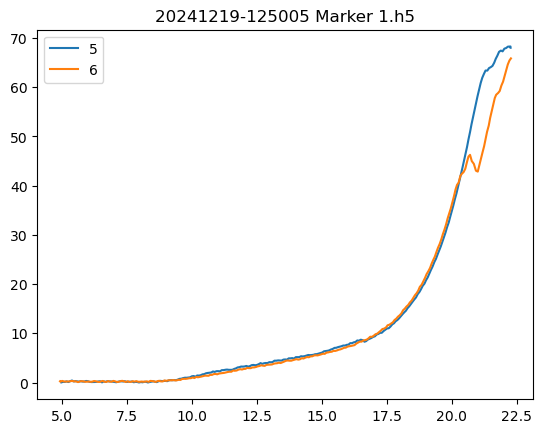

Choose Fd curve to fit too from: ['5', '6']


 5


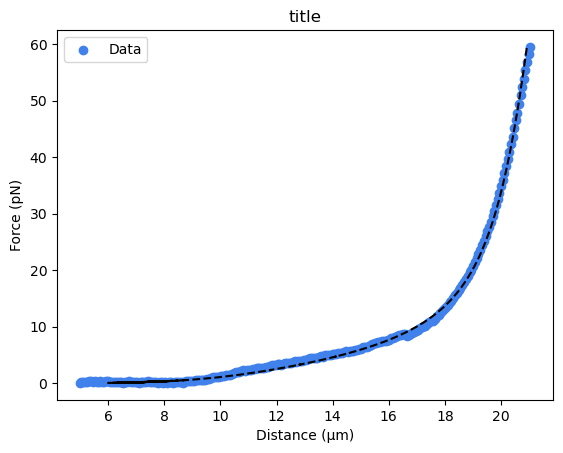

In [ ]:
def plot_fd_curves(fd_curves, file):
    """
    Plot force-distance curves and return the list of legend IDs.

    :param fd_curves: Dictionary of force-distance curves.
    :param file: File name.
    :return: List of legend IDs.
    """
    legend_ids = []
    for fd in fd_curves:
        if (fd_curves[fd].stop - fd_curves[fd].start) / 1000000000 < 10:
            continue
        legend_ids.append(fd)
        force = fd_curves[fd].f.data
        distance = fd_curves[fd].d.data
        plt.plot(distance, force)
    plt.title(file)
    plt.legend(legend_ids)
    plt.show()
    return legend_ids

def fit_gap_model(marker, fd_to_use, output_folder_fd, file):
    """
    Fit the gap model to the selected force-distance curve and save the results.

    :param marker: Pylake File object.
    :param fd_to_use: Selected force-distance curve ID.
    :param output_folder_fd: Path to the output folder.
    :param file: File name.
    """
    force = marker.fdcurves[fd_to_use].f.data
    distance = marker.fdcurves[fd_to_use].d.data

    gap_model_result, F, x_gap = initial_gap_fit(distance, force)
    
    kbp_ds = gap_model_result.params['kbp_ds'].value
    kbp_ss = gap_model_result.params['kbp_ss'].value
    fit_r2 = gap_model_result.rsquared

    fd_fitted(x_gap, F, gap_model_result, 'title')
    plt.show()

    gap_fit_dict = {'kbp_ss': kbp_ss, 'kbp_ds': kbp_ds, 'fit_r2': fit_r2, 'FD_curve_id': fd_to_use}
    gap_fit_df = pd.DataFrame(gap_fit_dict, index=[0])
    gap_fit_df.to_csv(f'{output_folder_fd}{file.removesuffix(".h5")}_fd{fd_to_use}.csv', index=False)

def process_files_fd(data_folder,marker_name):
    """
    Process marker.h5 file in the data folder to fit and classify force-distance curves.

    :param data_folder: Path to the data folder.
    """
    output_folder_fd = create_output_folder(data_folder, output_folder_name='gap_fd_fit/')

    marker = pylake.File(os.path.join(data_folder, marker_name))
    fd_curves = marker.fdcurves
    
    if len(fd_curves) == 0:return
    
    legend_ids = plot_fd_curves(fd_curves, marker_name)

    print(f'Choose Fd curve to fit too from: {legend_ids}')
    fd_to_use = str(input())

    fit_gap_model(marker, fd_to_use, output_folder_fd, marker_name)

# Define the data folder path
data_folder = '../test_folder/'
marker_name = '20241219-125005 Marker 1.h5'
# Process all files in the data folder
process_files_fd(data_folder,marker_name)
